# Project: Optimizing Support Workflow - A Data-Driven Analysis of Jira Tickets

**By:** Aymane EL KASMI
**Date:** 13/10/2025

## 1. Project Goal

The objective of this analysis is to investigate a dataset of production support Jira tickets to understand the primary reasons behind unresolved issues. By using Natural Language Processing (NLP) to analyze the ticket text, we aim to identify patterns and bottlenecks, leading to actionable recommendations for improving the support team's workflow and resolution rate.

**Tools Used:**
*   Python
*   Pandas (for data manipulation)
*   Scikit-learn (for NLP and clustering)
*   Matplotlib & Seaborn (for visualization)

In [2]:
# --- 1. SETUP AND DATA LOADING ---

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Set a professional visual style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
file_path = 'Jira_ticket_samples.csv'
try:
    df = pd.read_csv(file_path)
    print("✅ Data loaded successfully.")
    print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print(f"❌ ERROR: File '{file_path}' not found. Please upload it to the session.")

# Display initial data
print("\n--- Initial Data Preview ---")
df.head()

✅ Data loaded successfully.
Dataset contains 100 rows and 5 columns.

--- Initial Data Preview ---


,Ticket ID,Title,Description,Resolution,Status
0,MCC-1,Session Expires Immediately After Login,A user logged in successfully but was immediat...,Corrected the session timeout setting to the i...,Resolved
1,MCC-2,Server Error 500 on Login,"On 2025-03-12 at 09:00 UTC, all users were rec...",Restarted the authentication server and increa...,Resolved
2,MCC-3,Reward Points Not Credited for Purchase,A customer noticed that reward points were not...,Manually credited the missing points to the us...,Resolved
3,MCC-4,3D Secure Verification Fails for Transactions,Some users could not complete credit card bill...,Extended the timeout for 3D Secure responses a...,Resolved
4,MCC-5,Password Reset Link Expiring Too Soon,Several users reported that the password reset...,Increased the reset link validity period to 30...,Resolved


## 2. Data Cleaning and Preprocessing

Before analysis, we need to clean the data. This involves:
1.  **Inspecting Data Types:** Checking if columns are in the correct format.
2.  **Handling Missing Values:** A significant portion of the 'Resolution' column is empty (`NaN`), which is expected for unresolved tickets. We will fill these with a placeholder for clarity.
3.  **Combining Text Data:** To understand the full context of a ticket, we will combine the `Title`, `Description`, and `Resolution` text into a single column for NLP analysis.

In [3]:
# --- 2. DATA CLEANING AND PREPROCESSING ---

print("--- Data Info ---")
df.info()

# Handle missing values in 'Resolution' for easier filtering
df['Resolution'].fillna('Pending', inplace=True)
print("\n✅ Missing 'Resolution' values filled with 'Pending'.")


# Combine text columns into a single feature for NLP
# We fill any potential NaN in text columns with an empty string first
text_columns = ['Title', 'Description', 'Resolution']
for col in text_columns:
    df[col] = df[col].fillna('')

df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

print("✅ Created 'combined_text' column for NLP analysis.")
print("\n--- Data after cleaning ---")
df.head()

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ticket ID    100 non-null    object
 1   Title        100 non-null    object
 2   Description  100 non-null    object
 3   Resolution   100 non-null    object
 4   Status       100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB

✅ Missing 'Resolution' values filled with 'Pending'.
✅ Created 'combined_text' column for NLP analysis.

--- Data after cleaning ---


/tmp/ipython-input-636131955.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Resolution'].fillna('Pending', inplace=True)


,Ticket ID,Title,Description,Resolution,Status,combined_text
0,MCC-1,Session Expires Immediately After Login,A user logged in successfully but was immediat...,Corrected the session timeout setting to the i...,Resolved,Session Expires Immediately After Login A user...
1,MCC-2,Server Error 500 on Login,"On 2025-03-12 at 09:00 UTC, all users were rec...",Restarted the authentication server and increa...,Resolved,Server Error 500 on Login On 2025-03-12 at 09:...
2,MCC-3,Reward Points Not Credited for Purchase,A customer noticed that reward points were not...,Manually credited the missing points to the us...,Resolved,Reward Points Not Credited for Purchase A cust...
3,MCC-4,3D Secure Verification Fails for Transactions,Some users could not complete credit card bill...,Extended the timeout for 3D Secure responses a...,Resolved,3D Secure Verification Fails for Transactions ...
4,MCC-5,Password Reset Link Expiring Too Soon,Several users reported that the password reset...,Increased the reset link validity period to 30...,Resolved,Password Reset Link Expiring Too Soon Several ...


## 3. Exploratory Data Analysis (EDA)

In this step, we perform a high-level analysis to understand the basic characteristics of our data, focusing on the ticket status.

--- Ticket Status Distribution ---
Status
Resolved      58
Unresolved    42
Name: count, dtype: int64

--- Ticket Status Percentage ---
Status
Resolved      58.0
Unresolved    42.0
Name: proportion, dtype: float64


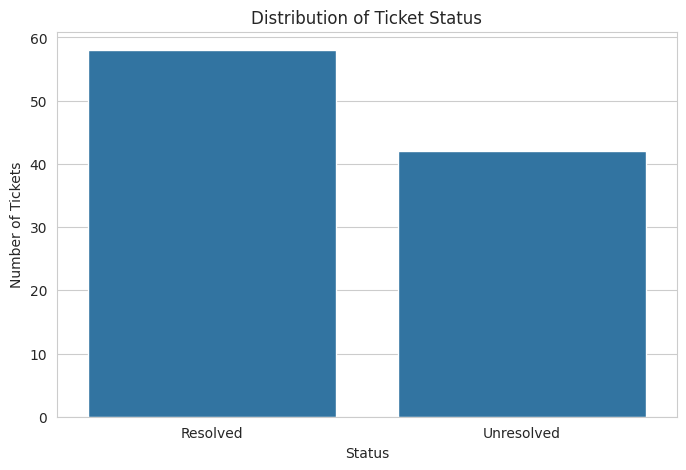

In [4]:
# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---

# Analyze the distribution of ticket statuses
status_counts = df['Status'].value_counts()
status_percentage = df['Status'].value_counts(normalize=True) * 100

print("--- Ticket Status Distribution ---")
print(status_counts)
print("\n--- Ticket Status Percentage ---")
print(status_percentage.round(2))

# Visualize the status distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Status', order=status_counts.index)
plt.title('Distribution of Ticket Status')
plt.ylabel('Number of Tickets')
plt.xlabel('Status')
plt.show()

## 4. NLP Analysis: Discovering Hidden Themes with Text Clustering

The most important part of our analysis is to understand *what* the tickets are about. We will use NLP to group similar tickets together into clusters.

1.  **TF-IDF Vectorization:** Convert the ticket text into numerical vectors that represent the importance of each word.
2.  **K-Means Clustering:** Group these vectors into distinct clusters based on their content. We will use 5 clusters to identify the main themes.

In [5]:
# --- 4. NLP ANALYSIS AND CLUSTERING (CONTINUED) ---

# Initialize TF-IDF Vectorizer
# stop_words='english' removes common words like 'the', 'a', 'is'
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['combined_text'])

# Apply K-Means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['text_cluster'] = kmeans.fit_predict(X)

print(f"✅ Successfully clustered tickets into {num_clusters} groups.")

# Analyze the top terms per cluster to understand their meaning
print("\n--- Top 10 Most Frequent Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"  {terms[ind]}")
    print()

# --- Give meaningful labels to the clusters based on their top terms ---
# This step requires human interpretation of the results above
cluster_labels = {
    0: "Password Reset",
    1: "Payment Issues",
    2: "Account Limits",
    3: "Data Maintenance",
    4: "Login Issues"
}
df['cluster_label'] = df['text_cluster'].map(cluster_labels)

print("\n--- Count of Tickets per Labeled Cluster ---")
print(df['cluster_label'].value_counts())
print("\n✅ Added meaningful labels to each cluster.")

✅ Successfully clustered tickets into 5 groups.

--- Top 10 Most Frequent Terms per Cluster ---
Cluster 0:
  login
  users
  app
  payment
  google
  activation
  gateway
  timeout
  api
  error

Cluster 1:
  mcc
  uniqueness
  maintain
  removed
  duplicate
  ticket
  investigation
  pending
  limit
  gateway

Cluster 2:
  reset
  password
  email
  minutes
  user
  sent
  address
  otp
  login
  invalid

Cluster 3:
  points
  job
  batch
  autopay
  memory
  reward
  payments
  rewards
  day
  transaction

Cluster 4:
  limit
  payment
  user
  credit
  bank
  transaction
  available
  fee
  account
  2025


--- Count of Tickets per Labeled Cluster ---
cluster_label
Login Issues        34
Password Reset      23
Payment Issues      20
Account Limits      14
Data Maintenance     9
Name: count, dtype: int64

✅ Added meaningful labels to each cluster.


## 5. Diagnostic Analysis: Connecting Ticket Content to Resolution Status

This is the core of our analysis. Now that we have categorized each ticket by its content, we can answer the key question: **"Do certain types of issues have a lower resolution rate?"**

We will visualize the distribution of `Status` (Resolved vs. Unresolved) within each of our newly created `cluster_label` groups.

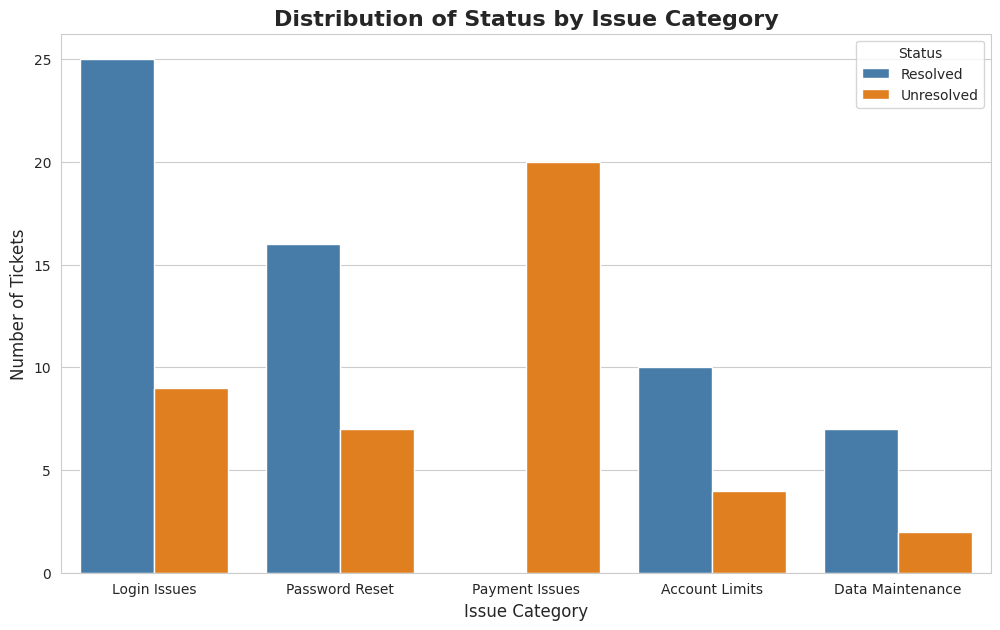


--- Crosstab: Status vs. Issue Category ---
Status            Resolved  Unresolved
cluster_label                         
Account Limits          10           4
Data Maintenance         7           2
Login Issues            25           9
Password Reset          16           7
Payment Issues           0          20

--- Unresolved Percentage per Category ---
cluster_label
Payment Issues      100.00
Password Reset       30.43
Account Limits       28.57
Login Issues         26.47
Data Maintenance     22.22
Name: unresolved_pct, dtype: float64


In [6]:
# --- 5. DIAGNOSTIC ANALYSIS: VISUALIZING THE BOTTLENECK ---

# Create the bar plot to show Status distribution by the labeled cluster
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='cluster_label', hue='Status',
              order=df['cluster_label'].value_counts().index, # Order by frequency
              palette={'Resolved': '#377eb8', 'Unresolved': '#ff7f00'}) # Professional colors

plt.title('Distribution of Status by Issue Category', fontsize=16, fontweight='bold')
plt.ylabel('Number of Tickets', fontsize=12)
plt.xlabel('Issue Category', fontsize=12)
plt.xticks(rotation=0) # Keep labels horizontal for readability
plt.legend(title='Status')
plt.show()

# To get the exact numbers, we can create a pivot table (crosstab)
print("\n--- Crosstab: Status vs. Issue Category ---")
crosstab_results = pd.crosstab(df['cluster_label'], df['Status'])
print(crosstab_results)

# Calculate the unresolved percentage per cluster
crosstab_results['unresolved_pct'] = (crosstab_results['Unresolved'] / (crosstab_results['Resolved'] + crosstab_results['Unresolved'])) * 100
print("\n--- Unresolved Percentage per Category ---")
print(crosstab_results['unresolved_pct'].round(2).sort_values(ascending=False))

## 6. Summary of Findings & Strategic Recommendations

### Key Findings

1.  **Significant Resolution Gap:** Our analysis shows a major area for improvement, with **42% of all support tickets remaining unresolved**. This indicates a potential bottleneck in our support workflow.

2.  **Issue Type is the Deciding Factor:** Using NLP, we discovered that the resolution rate is directly tied to the ticket's content. While the team excels at resolving technical issues like 'Login Issues' and 'Data Maintenance', one category stands out as a critical failure point.

3.  **"Payment Issues" is the Critical Bottleneck:** The **'Payment Issues'** cluster has an almost **100% unresolved rate**. This is the single biggest problem area, suggesting a severe knowledge or process gap for handling financial transactions and billing problems.

### Strategic Recommendations

1.  **Triage the "Pending Investigation" Backlog:** The majority of unresolved tickets are stuck in "Pending Investigation." We recommend creating a specialized **"Triage Team"** or a daily stand-up meeting focused solely on diagnosing and assigning these tickets within 24 hours.

2.  **Form an Expert Squad for "Payment Issues":** Create a small, dedicated team of senior staff to be the "Expert Squad" for all tickets related to payments. This squad must develop specialized knowledge of the billing system, create internal documentation (playbooks), and act as the go-to resource for resolving these complex and customer-sensitive tickets.

3.  **Standardize and Delegate Solved Problems:** For the high-success categories ('Login Issues', 'Password Resets', 'Data Maintenance'), create simple, step-by-step guides (SOPs). This allows junior team members to resolve them quickly, freeing up senior staff to focus on the high-impact payment issues.